In [24]:
import torch
import torch.nn as nn
from torch.optim import AdamW, Optimizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scratchers.attn import Attention, MultiheadAttention
from scratchers.transformer import TransformerBlock, TransformerDecoder, Config

# Data generation

In [2]:
SOURCE_SEQ_LEN = 6
TARGET_SEQ_LEN = 6

DATA_SIZE = 1200
TRAIN_SIZE = int(1200 * 0.8)
TEST_SIZE = 1200 - TRAIN_SIZE

radii = np.random.ranf((DATA_SIZE)) * 9 + 1
starting_radian = np.random.ranf((DATA_SIZE)) * 2 * np.pi
directions = np.random.randint(2, size=DATA_SIZE) * 2 - 1

def to_cartesian(
    radius: float,
    start_radian: float, 
    direction: int
):
    delta = 2 * np.pi / (SOURCE_SEQ_LEN + TARGET_SEQ_LEN)
    seq = np.array([
        np.array([
            radius * np.cos(start_radian + (i * direction * delta)),
            radius * np.sin(start_radian + (i * direction * delta))
        ])
        for i in range(SOURCE_SEQ_LEN + TARGET_SEQ_LEN)
    ])
    source_seq = seq[:-1]
    target_seq = seq[1:]
    return source_seq, target_seq

def make_data():
    X = np.empty((DATA_SIZE, (SOURCE_SEQ_LEN + TARGET_SEQ_LEN) - 1, 2))
    Y = np.empty((DATA_SIZE, (SOURCE_SEQ_LEN + TARGET_SEQ_LEN) - 1, 2))
    for idx, (radius, start_radian, direction) in enumerate(zip(radii, starting_radian, directions)):
        x, y = to_cartesian(radius, start_radian, direction)
        X[idx, :, :] = x
        Y[idx, :, :] = y

    return (
        torch.from_numpy(X[:TRAIN_SIZE]).float(), 
        torch.from_numpy(Y[:TRAIN_SIZE]).float(),
        torch.from_numpy(X[TRAIN_SIZE:]).float(), 
        torch.from_numpy(Y[TRAIN_SIZE:]).float()
    )

X_train, y_train, X_test, y_test = make_data()

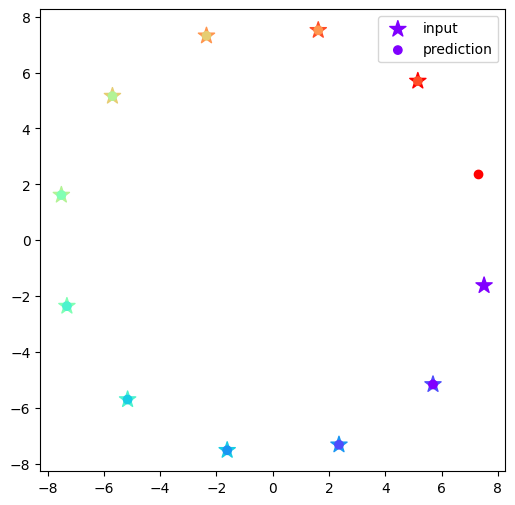

In [26]:
def plot_circle(input, prediction, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    colors = cm.rainbow(np.linspace(0, 1, len(input)))
    plt.scatter(
        input[:, 0], input[:, 1], label="input", marker="*", s=150, color=colors
    )
    plt.scatter(prediction[:, 0], prediction[:, 1], label="prediction", color=colors)
    plt.legend()

plot_circle(X_train[7], y_train[7])

# Train

In [4]:
cfg = Config(
    input_size=2, 
    attn_d_k=16,
    transformer_proj_dim=32,
    dropout=0.2,
    nlayers=2,
    is_self_attn=False,
    max_seq_len=TARGET_SEQ_LEN,
    nheads=2
)

def attn_factory(config: Config):
    return MultiheadAttention(
        input_size=config.input_size,
        d_k=config.attn_d_k,
        nheads=config.nheads,
        is_self_attn=config.is_self_attn,
        dropout=config.dropout
    )
    
decoder = TransformerDecoder(cfg, attn_factory)

In [7]:
class Trainer:

    def __init__(
        self,
        train_data_loader: DataLoader,
        test_data_loader: DataLoader,
        optimizer: Optimizer,
        model: nn.Module,
        epochs: int = 10,
    ):
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader
        self.optimizer = optimizer
        self.model = model
        self.epochs = epochs

    def train(self, loss_fn: callable):
        for epoch in range(self.epochs):
            losses = []
            for x_batch, y_batch in self.train_data_loader:
                out = self.model(x_batch)
                loss = loss_fn(out, y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                losses.append(loss.detach().cpu().numpy())

            print(f"Train loss at epoch ({epoch}): ", np.array(losses).mean())

            with torch.no_grad():
                test_losses = []
                for x_batch, y_batch in self.test_data_loader:
                    out = self.model(x_batch)
                    loss = loss_fn(out, y_batch)
                    test_losses.append(loss.detach().cpu().numpy())

                print(f"Test loss at epoch ({epoch}): ", np.array(test_losses).mean())

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
trainer = Trainer(
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
    optimizer=AdamW(decoder.parameters()),
    model=decoder,
    epochs=15
)
trainer.train(loss_fn=nn.MSELoss())

Train loss at epoch (0):  3.2077136
Test loss at epoch (0):  3.181623
Train loss at epoch (1):  3.1551015
Test loss at epoch (1):  3.1810536
Train loss at epoch (2):  3.1674469
Test loss at epoch (2):  3.1884143
Train loss at epoch (3):  3.1785862
Test loss at epoch (3):  3.1935408
Train loss at epoch (4):  3.1684225
Test loss at epoch (4):  3.2351236
Train loss at epoch (5):  3.1679108
Test loss at epoch (5):  3.1629117
Train loss at epoch (6):  3.1498375
Test loss at epoch (6):  3.2525659
Train loss at epoch (7):  3.1450398
Test loss at epoch (7):  3.2110755
Train loss at epoch (8):  3.1627913
Test loss at epoch (8):  3.1816523
Train loss at epoch (9):  3.131089
Test loss at epoch (9):  3.165996
Train loss at epoch (10):  3.1456583
Test loss at epoch (10):  3.0844138
Train loss at epoch (11):  3.1531928
Test loss at epoch (11):  3.180206
Train loss at epoch (12):  3.174253
Test loss at epoch (12):  3.1691477
Train loss at epoch (13):  3.1138124
Test loss at epoch (13):  3.1041846
Tra

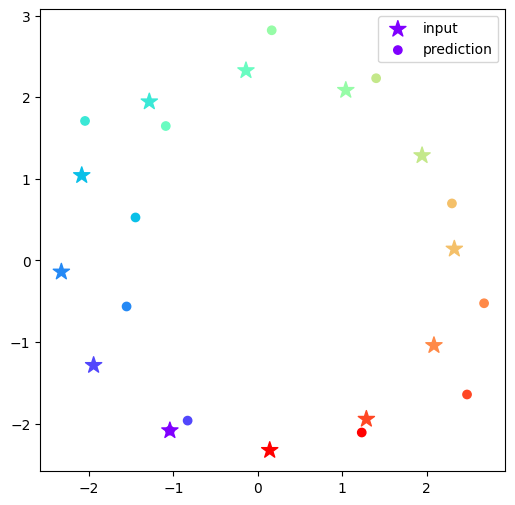

In [43]:
x_sample, y_sample = test_dataset[np.random.randint(0, TEST_SIZE)]
predictions = decoder.forward(x_sample.unsqueeze(0))[0]
labels = torch.cat((x_sample, y_sample[-1:]))

plot_circle(input= labels.detach().numpy(), prediction=torch.cat((labels[0:1, :], predictions)).detach().numpy())